In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# We need these two classes to set proper ticklabels for Cartopy maps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import pyproj
import verde as vd
from verde.base import check_fit_input

In [2]:
# Fetch the GPS data from the U.S. West coast. 
data = vd.datasets.fetch_california_gps()
region = vd.get_region((data.longitude, data.latitude))
projection = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())

# Separate the data into a training and testing set for cross-validation
train, test = train_test_split(np.arange(data.shape[0]), random_state=1)

train_data = data.loc[train]
test_data = data.loc[test]

spacing = 20/60

In [3]:
force_region = vd.get_region(projection(data.longitude.values, data.latitude.values))
force_spacings = [spacing*111e3*scale for scale in [2, 2.5, 3]]
force_spacings.append(None)
dampings = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
poissons = [-1, 0.5, 1]
print(force_spacings)

[74000.0, 92500.0, 111000.0, None]


In [20]:
def cross_val_score(estimator, coordinates, data, weights=None, projection=None, cv=None):
    coordinates, data, weights = check_fit_input(coordinates, data, weights, ravel=False)
    if cv is None:
        cv = KFold()
    if projection is not None:
        coordinates = projection(*coordinates)
    ndata = data[0].size
    scores = []
    for train, test in cv.split(np.arange(ndata)):
        train_data, test_data = split_data(train, test, coordinates, data, weights)
        estimator.fit(*train_data)
        scores.append(estimator.score(*test_data))        
    return np.array(scores)

def split_data(train, test, coordinates, data, weights):
    split = tuple((separate(i, index) for i in (coordinates, data, weights))
                  for index in [train, test])
    return split
            
def separate(data, index):
    if any(i is None for i in data):
        return data
    return tuple(i[index] for i in data)    

In [11]:
%%time
scores = []
estimators = []
for poisson in poissons:
    for fspacing in force_spacings:
        for damping in dampings:
            chain = vd.Chain([
                ('mean', vd.BlockMean(spacing*111e3, uncertainty=True)),
                ('trend', vd.VectorTrend(degree=1)),
                ('spline', vd.Vector2D(poisson=poisson, spacing=fspacing, damping=damping))])
            chain.fit(projection(train_data.longitude.values, train_data.latitude.values), 
                      (train_data.velocity_east, train_data.velocity_north),
                      weights=(1/train_data.std_east**2, 1/train_data.std_north**2))
            score = chain.score(projection(test_data.longitude.values, test_data.latitude.values),
                                (test_data.velocity_east, test_data.velocity_north),
                                vd.variance_to_weights((test_data.std_east**2, test_data.std_north**2)))
            scores.append(score)
            estimators.append(chain)

CPU times: user 1min 16s, sys: 917 ms, total: 1min 17s
Wall time: 32.7 s


In [12]:
print("Best score:", np.max(scores))
chain = estimators[np.argmax(scores)]
print("Best estimator:")
print(chain)

Best score: 0.9697967678176516
Best estimator:
Chain(steps=[('mean', BlockMean(adjust='spacing', center_coordinates=False, region=None,
     spacing=37000.0, uncertainty=True)), ('trend', VectorTrend(degree=1)), ('spline', Vector2D(damping=0.001,
     force_region=(-11187651.930044347, -10374081.660660725, 3058625.116888401, 4142872.3336011297),
     fudge=1e-05, poisson=0.5, shape=None, spacing=74000.0))])


In [13]:
chain.fit(projection(data.longitude.values, data.latitude.values),
          (data.velocity_east, data.velocity_north),
          (1/data.std_east**2, 1/data.std_north**2))

Chain(steps=[('mean', BlockMean(adjust='spacing', center_coordinates=False, region=None,
     spacing=37000.0, uncertainty=True)), ('trend', VectorTrend(degree=1)), ('spline', Vector2D(damping=0.001,
     force_region=(-11187651.930044347, -10374081.660660725, 3058625.116888401, 4142872.3336011297),
     fudge=1e-05, poisson=0.5, shape=None, spacing=74000.0))])

In [14]:
grid = chain.grid(region, spacing=spacing, projection=projection,
                  dims=['latitude', 'longitude'])
mask = vd.distance_mask(np.meshgrid(grid.longitude, grid.latitude), (data.longitude, data.latitude), 
                       maxdist=0.5)
grid = grid.where(~mask)

In [15]:
def setup_map(ax, title):
    "Make a map of the given trend component on the given axes"
    ax.set_title(title)
    # Setup the map ticks
    ax.set_xticks(np.arange(-124, -115, 4), crs=crs)
    ax.set_yticks(np.arange(33, 42, 2), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.add_feature(cfeature.LAND, facecolor='#eeeeee')
    ax.add_feature(cfeature.OCEAN)
    ax.set_extent((234, 246, 31, 43), crs=crs)

/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


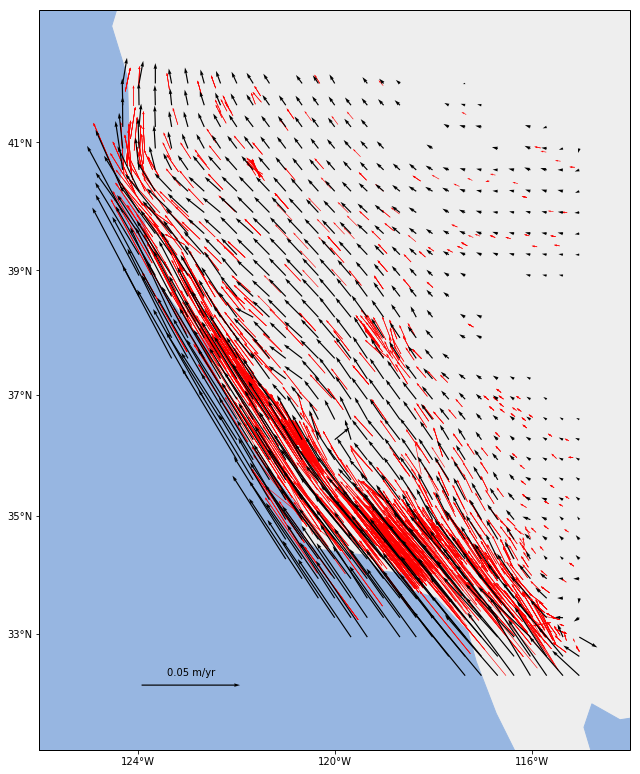

In [16]:
# Make a plot of the data using Cartopy to handle projections and coastlines
fig, axes = plt.subplots(1, 1, figsize=(9, 12),
                         subplot_kw=dict(projection=ccrs.Mercator()))
crs = ccrs.PlateCarree()
# Plot the two trend components
#ax = axes[0]
ax = axes
ax.quiver(data.longitude.values, data.latitude.values,
          data.velocity_east.values, data.velocity_north.values,
          scale=0.3, transform=crs, color='r', width=0.001)
#ax = axes[0]
#setup_map(ax, '')

tmp = ax.quiver(grid.longitude.values, grid.latitude.values,
          grid.east_component.values, grid.north_component.values,
          scale=0.3, transform=crs, width=0.002)


ax.quiverkey(tmp, 0.3, 0.15, 0.05, label='0.05 m/yr', coordinates='figure')

setup_map(ax, '')

plt.tight_layout()
plt.show()


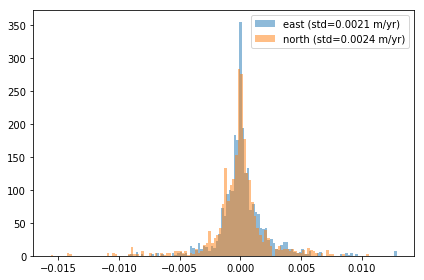

In [17]:
predicted = chain.predict(projection(data.longitude.values, data.latitude.values))
residuals = (data.velocity_east - predicted[0], data.velocity_north - predicted[1])
fig = plt.figure()
ax = plt.axes()
ax.hist(residuals[0], alpha=0.5, bins='auto', label='east (std={:.4f} m/yr)'.format(residuals[0].std()))
ax.hist(residuals[1], alpha=0.5, bins='auto', label='north (std={:.4f} m/yr)'.format(residuals[1].std()))
ax.legend()
plt.tight_layout()